<a href="https://colab.research.google.com/github/juhumkwon/Data/blob/main/%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5_%EB%B3%B4%EC%99%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[100] Loss: 5.3171, Reward: 1.00, Accuracy: 1
[200] Loss: 0.6434, Reward: 1.00, Accuracy: 1
[300] Loss: 0.1300, Reward: 1.00, Accuracy: 1
[400] Loss: 0.0293, Reward: 0.50, Accuracy: 1
[500] Loss: 0.0233, Reward: 0.50, Accuracy: 1
[600] Loss: 0.0119, Reward: 1.00, Accuracy: 1
[700] Loss: 0.0042, Reward: 0.50, Accuracy: 1
[800] Loss: 0.0023, Reward: 0.50, Accuracy: 1
[900] Loss: 0.0013, Reward: 0.50, Accuracy: 1
[1000] Loss: 0.0006, Reward: -2.00, Accuracy: 0


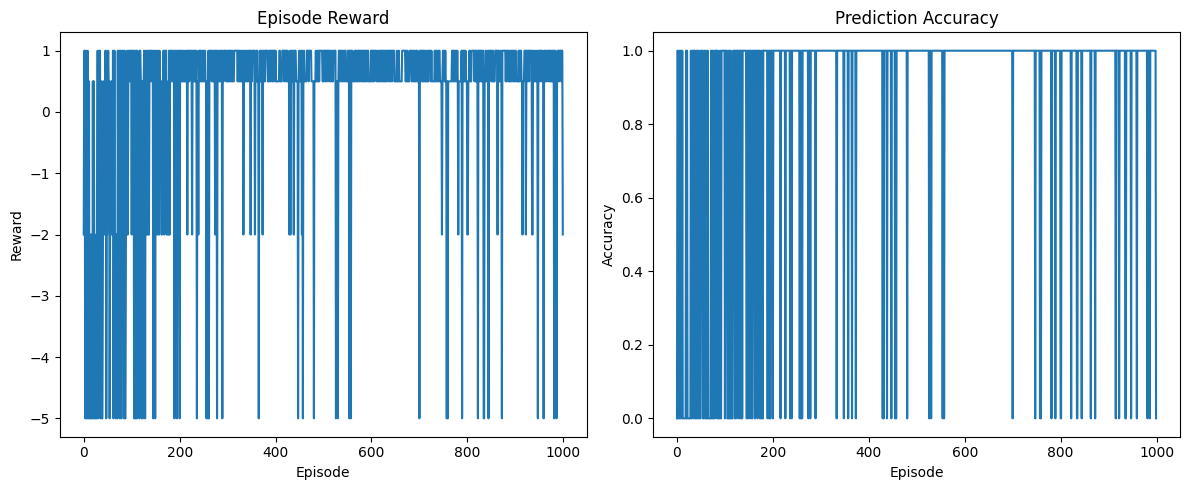

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54728 (\N{HANGUL SYLLABLE HEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/

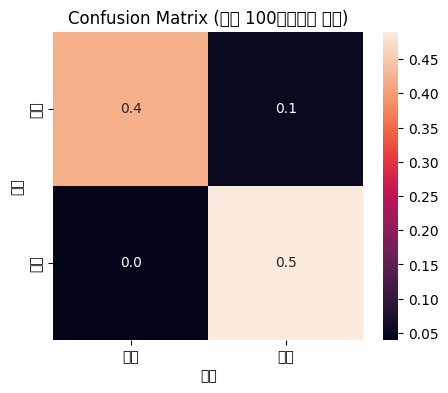

In [1]:

import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from collections import deque
import seaborn as sns

# ==== 환경 설정 ====
def generate_traffic():
    port = np.random.choice([22, 80, 443, 3389])
    reputation = np.random.choice([0, 1])  # 0: 악성, 1: 정상
    length = np.random.randint(50, 1500)
    proto = np.random.choice([0, 1])  # 0: TCP, 1: UDP
    return np.array([port / 1000, reputation, length / 1500, proto], dtype=np.float32)

def get_reward(action, traffic):
    label = traffic[1]
    if action == 1 and label == 0: return +1
    elif action == 1 and label == 1: return -2
    elif action == 0 and label == 0: return -5
    else: return +0.5

# ==== Q-Network 정의 ====
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(4,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(2, activation='linear')
    ])
    return model

# ==== 하이퍼파라미터 ====
gamma = 0.95
batch_size = 64
buffer_size = 10000
target_update_freq = 20
epsilon_decay = 0.995
min_epsilon = 0.1
learning_rate = 0.001

# ==== 모델, 버퍼 초기화 ====
main_model = build_model()
target_model = build_model()
target_model.set_weights(main_model.get_weights())
optimizer = tf.keras.optimizers.Adam(learning_rate)

replay_buffer = deque(maxlen=buffer_size)

# ==== 통계 기록 ====
rewards_log = []
acc_log = []
conf_matrix_log = []

# ==== 학습 루프 ====
epsilon = 1.0
for episode in range(1, 1001):
    state = generate_traffic()
    total_reward = 0
    correct = 0
    confusion = np.zeros((2, 2))  # [true][pred]

    for _ in range(1):  # 한 에피소드당 1 스텝 (샘플이 독립적이므로)
        if np.random.rand() < epsilon:
            action = np.random.randint(2)
        else:
            q_vals = main_model(np.expand_dims(state, axis=0)).numpy()[0]
            action = np.argmax(q_vals)

        reward = get_reward(action, state)
        next_state = generate_traffic()
        done = True  # 한 스텝만

        replay_buffer.append((state, action, reward, next_state, done))
        total_reward += reward

        # accuracy/confusion
        true_label = int(state[1] == 0)  # 악성이면 1 (차단이 정답)
        pred_label = int(action == 1)
        if true_label == pred_label:
            correct += 1
        confusion[true_label][pred_label] += 1

        state = next_state

    # ===== 학습 수행 =====
    if len(replay_buffer) >= batch_size:
        minibatch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        actions = np.array(actions)
        rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=np.float32)

        # Double DQN: action selection from main_model, value from target_model
        next_q_main = main_model(next_states)
        next_actions = tf.argmax(next_q_main, axis=1)

        next_q_target = target_model(next_states).numpy()
        next_q_values = np.array([next_q_target[i, a] for i, a in enumerate(next_actions)])

        target_qs = rewards + gamma * next_q_values * (1 - dones)

        with tf.GradientTape() as tape:
            q_preds = main_model(states)
            chosen_qs = tf.reduce_sum(q_preds * tf.one_hot(actions, 2), axis=1)
            loss = tf.reduce_mean(tf.square(chosen_qs - target_qs))

        grads = tape.gradient(loss, main_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, main_model.trainable_variables))

    # ===== 타깃 네트워크 동기화 =====
    if episode % target_update_freq == 0:
        target_model.set_weights(main_model.get_weights())

    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # ===== 통계 기록 =====
    rewards_log.append(total_reward)
    acc_log.append(correct)
    conf_matrix_log.append(confusion)

    if episode % 100 == 0:
        print(f"[{episode}] Loss: {loss.numpy():.4f}, Reward: {total_reward:.2f}, Accuracy: {correct}")

# ==== 성능 시각화 ====
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards_log)
plt.title("Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1, 2, 2)
plt.plot(acc_log)
plt.title("Prediction Accuracy")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# ==== 최종 Confusion Matrix 평균 시각화 ====
avg_conf_matrix = sum(conf_matrix_log[-100:]) / 100  # 최근 100개 평균
plt.figure(figsize=(5, 4))
sns.heatmap(avg_conf_matrix, annot=True, fmt=".1f", xticklabels=['허용', '차단'], yticklabels=['정상', '악성'])
plt.title("Confusion Matrix (최근 100에피소드 평균)")
plt.xlabel("예측")
plt.ylabel("실제")
plt.show()